# [GD-01] NLP_SentencePiece
"Going Deeper Node 2. Making Nice Vocab Dictionary" / 2022. 03. 23 (WED) 이형주

## Contents
---
- **1. Environment Setup**
- **2. Modeling**
- **3. Project Retrospective**

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

## 1. Environment Setup

In [1]:
# konlpy 설치
!pip install konlpy==0.5.0 --upgrade

In [2]:
# Sentencepiece 설치
!pip install sentencepiece --upgrade

In [3]:
# 필요한 라이브러리 로드 !
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import konlpy

In [4]:
# Colab Pro GPU 정보
# 새로운 환경에서 진행하는 만큼 실행시켜 본다.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 23 19:38:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Colab Pro Ram 정보
# 새로운 환경에서 진행하는 만큼 실행시켜 본다.
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


**원래는 Google Drive에 업로드 후 로드하려 하였으나, 1Gbps 인터넷 환경에서도 업로드 시간이 총 40분 정도로 과다하게 소요되는 관계로 웹 로드로 대체한다. 사용하는 방법은 아래 링크를 참조하여 urlretrieve, urllib.request를 활용하였다.**

Source: https://han-py.tistory.com/320

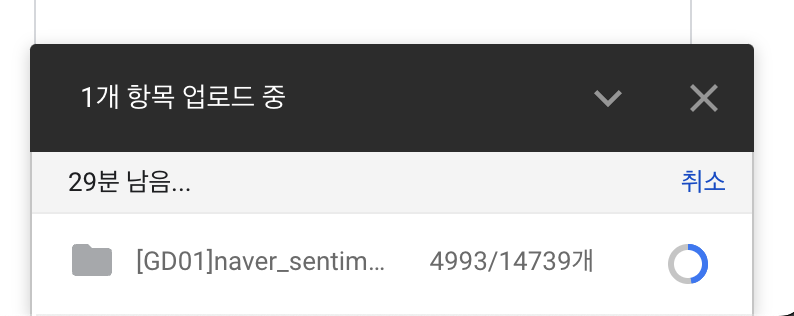

In [6]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f345e1e1810>)

In [7]:
import pandas as pd
naver_movie_review_df = pd.read_table('ratings.txt')
print('데이터 전체 갯수는:', len(naver_movie_review_df), '개 입니다.')

데이터 전체 갯수는: 200000 개 입니다.


**Data Description**

1. Each file is consisted of three columns: id, document, label
  + id: The review id, provieded by Naver
  + document: The actual review
  + label: The sentiment class of the review. (0: negative, 1: positive)
  + Columns are delimited with tabs (i.e., .tsv format; but the file extension is .txt for easy access for novices)
2. 200K reviews in total
  + ratings.txt: All 200K reviews
  + ratings_test.txt: 50K reviews held out for testing
  + ratings_train.txt: 150K reviews for training
3. Characteristics
  + All reviews are shorter than 140 characters
  + Each sentiment class is sampled equally (i.e., random guess yields 50% accuracy)
  + 100K negative reviews (originally reviews of ratings 1-4)
  + 100K positive reviews (originally reviews of ratings 9-10)
Neutral reviews (originally reviews of ratings 5-8) are excluded

In [8]:
# index로 번호가, id에는 작성자 아이디가, document에 리뷰 내용이 있다.
naver_movie_review_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### EDA & Data Pre-Processing

**결측치부터 찾아서 전처리 해보자. 위에서 데이터 전체 갯수는 200,000개 였다.**



In [9]:
# 결측치 숫자를 체크해본다.
naver_movie_review_df.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [10]:
# 결측치 8개는 빠르게 제거하자.
naver_movie_review_df = naver_movie_review_df.dropna(how='any')
print(naver_movie_review_df.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[199992 rows x 3 columns]>


In [11]:
# 여기에서 혹시 모를 중복 데이터를 한번 더 거른다. 갯수는 194,543개가 되었다.
duplicate_data_removed = naver_movie_review_df.drop_duplicates('document')
print('결측치 제거에, 중복 데이터까지 거른 리뷰 갯수는:',len(duplicate_data_removed),'개 입니다.')

결측치 제거에, 중복 데이터까지 거른 리뷰 갯수는: 194543 개 입니다.


In [12]:
# 깨끗하게 정리한 'document', 리뷰가 있는 영역을 naver_movie_review_cleaned로 선언한다.
naver_movie_review_cleaned = duplicate_data_removed['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


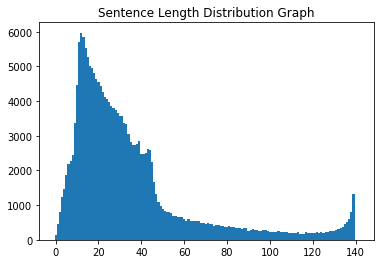

In [13]:
# 최장 1000자, 최저 0자로 해서 naver_movie_review_cleaned에 있는 리뷰들 길이가 어떻게 분포되어 있는지를 본다.
# 도식화된 그림에서 가로는 리뷰의 길이, 세로는 리뷰의 갯수가 되겠다.

min_len = 1000
max_len = 0
sum_len = 0

for sen in naver_movie_review_cleaned:
    length = len(sen)
    if min_len > length: 
        min_len = length
        
    if max_len < length: 
        max_len = length
    
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(naver_movie_review_cleaned))

sentence_length = np.zeros((max_len), dtype=int)
#dtype=np.int 에러는 메시지 그대로 np.int -> int로 바꾸면 해결된다.
  #DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

for sen in naver_movie_review_cleaned:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution Graph")
plt.show()

# 평균 10~50자 선에서 대부분의 데이터가 분포되어 있다.
# 50~140자에 있는 데이터들이 정말 중요한게 아니라면, 50자 이후는 다 날려도 될 것 같다.

In [14]:
# 각 문장 길이별 리뷰 분포를 수치로도 비교해 보자

def sentence_len(max_len, review_list):
    cnt = 0
    for s in review_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('샘플 길이가 %s 이하 비율은: %s'%(max_len, (cnt/len(review_list))*100),'입니다.')

sentence_len(36, naver_movie_review_cleaned)  # 평균
sentence_len(142, naver_movie_review_cleaned)  # 최장 
sentence_len(70, naver_movie_review_cleaned)  # 중앙
sentence_len(50, naver_movie_review_cleaned)
sentence_len(60, naver_movie_review_cleaned)

샘플 길이가 36 이하 비율은: 66.08616090016089 입니다.
샘플 길이가 142 이하 비율은: 100.0 입니다.
샘플 길이가 70 이하 비율은: 88.66523082300571 입니다.
샘플 길이가 50 이하 비율은: 82.05640912291884 입니다.
샘플 길이가 60 이하 비율은: 85.86739178484962 입니다.


In [15]:
# 최장으로 쓴 142자 글은 무엇으로 적혀 있을까?

def who_are_you_for_short_long_sentences(raw, length):
    count = 0

    for sen in raw:
      if len(sen) == length:
          print(sen)
          count += 1
          if count > 100: return

who_are_you_for_short_long_sentences(naver_movie_review_cleaned, 142)

영화 초반을 보면서 ' 좀 허항된 . 황당한 코믹스런 ' 연출이 되겠다란 생각을 하고 보기시작했는데 .. 연주가 처음 시작되는 부분에서 저도 모르게 눈가가 초촉해 지기시작하더군요 .. 이유는 모르겠네요 ... 자유에 대한 갈증과 박해에 대한 내용을 &gt


In [16]:
# 최단으로 쓴 1글자 글은 무엇으로 적혀 있을까?
def who_are_you_for_short_long_sentences(raw, length):
    count = 0

    for sen in raw:
      if len(sen) == length:
          print(sen)
          count += 1
          if count > 100: return

who_are_you_for_short_long_sentences(naver_movie_review_cleaned, 1)
# 유용한 데이터는 아닌 것 같다. 감정표현을 특수문자로 극도로 줄였을 순 있지만, 분포도를 보니 1~10글자 까지는 날려도 될 것 같다.

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


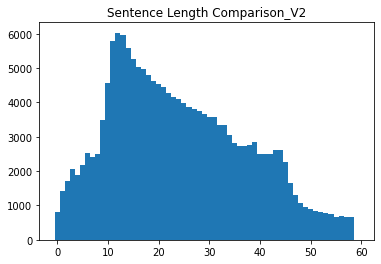

In [17]:
# 10글자 ~ 60글자로 범위를 좁힌다.

max_len = 60   
min_len = 10
modified_corpus_final = [sentence for sentence 
                         in naver_movie_review_cleaned 
                         if (len(sentence) < max_len) & (len(sentence) >= min_len)]

# Source: https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-02%5DSentencePiece.ipynb
modified_corpus_final = []
modified_corpus_label = []  
for sentence, label in zip(naver_movie_review_df['document'], naver_movie_review_df['label']):    
    if (len(sentence) < max_len):     
        modified_corpus_final.append(sentence)  
        modified_corpus_label.append(label)

train_data = naver_movie_review_cleaned[naver_movie_review_cleaned.str.len() <= max_len]
#naver_movie_review_cleaned는 위에서 중복제거 후 duplicate_data_removed['document']와 같다고 선언했다.
  
sentence_length = np.zeros((max_len), dtype=int)
#dtype=np.int 에러는 메시지 그대로 np.int -> int로 바꾸면 해결된다.

for sen in modified_corpus_final:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Comparison_V2")
plt.show()

In [18]:
# 처음에 데이터 열었을 때 갯수
print(len(naver_movie_review_df))
# 결측치 제거, 중복 제거 후 데이터 갯수
print(len(naver_movie_review_cleaned))
# 데이터 범위를 60자로 제한한 후 데이터 갯수
print(len(train_data))

199992
194543
167049


## 2. Modeling

In [19]:
# 모델링에 필요한 데이터도 깃헙에서 바로 가져온다.
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/haven-jeon/ko_en_neural_machine_translation/master/korean_parallel_corpora/korean-english-v1/korean-english-park.train.ko", filename="korean-english-park.train.ko")

('korean-english-park.train.ko', <http.client.HTTPMessage at 0x7f33d2bdb550>)

In [20]:
import sentencepiece as spm
temp_train_file = urllib.request.urlretrieve("https://raw.githubusercontent.com/haven-jeon/ko_en_neural_machine_translation/master/korean_parallel_corpora/korean-english-v1/korean-english-park.train.ko", filename="korean-english-park.train.ko")
vocab_size = 8000

# Unigram 8K
spm.SentencePieceTrainer.Train('--input=korean-english-park.train.ko --model_prefix=korean_spm_unigram_8k --vocab_size=8000'.format(temp_train_file, vocab_size))
# Unigram 16K
spm.SentencePieceTrainer.Train('--input=korean-english-park.train.ko --model_prefix=korean_spm_unigram_16k --vocab_size=16000'.format(temp_train_file, vocab_size*2))
# BPE 8K
spm.SentencePieceTrainer.Train('--input=korean-english-park.train.ko --model_prefix=korean_spm_bpe_8k --model_type=bpe --vocab_size=8000'.format(temp_train_file, vocab_size))
# BPE 16K
spm.SentencePieceTrainer.Train('--input=korean-english-park.train.ko --model_prefix=korean_spm_bpe_16k --model_type=bpe --vocab_size=16000'.format(temp_train_file, vocab_size*2))

In [21]:
!ls -l korean_spm_unigram_8k*
!ls -l korean_spm_unigram_16k*
!ls -l korean_spm_bpe_8k*
!ls -l korean_spm_bpe_16k*

-rw-r--r-- 1 root root 376471 Mar 23 19:38 korean_spm_unigram_8k.model
-rw-r--r-- 1 root root 145963 Mar 23 19:38 korean_spm_unigram_8k.vocab
-rw-r--r-- 1 root root 534523 Mar 23 19:39 korean_spm_unigram_16k.model
-rw-r--r-- 1 root root 310962 Mar 23 19:39 korean_spm_unigram_16k.vocab
-rw-r--r-- 1 root root 371579 Mar 23 19:39 korean_spm_bpe_8k.model
-rw-r--r-- 1 root root 116816 Mar 23 19:39 korean_spm_bpe_8k.vocab
-rw-r--r-- 1 root root 524521 Mar 23 19:39 korean_spm_bpe_16k.model
-rw-r--r-- 1 root root 259754 Mar 23 19:39 korean_spm_bpe_16k.vocab


In [22]:
def performance_test(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('죽음과결혼은미룰수록좋다.',1, 0.0)) #갓갓 명언

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [23]:
# Unigram Vocab 8K
performance_test(model='korean_spm_unigram_8k.model')
print('korean_spm_unigram_8k')

# Unigram Vocab 16K
## 형태소 구분 굿굿!
performance_test(model='korean_spm_unigram_16k.model')
print('korean_spm_unigram_16k')

# BPE Vocab 8K
performance_test(model='korean_spm_bpe_8k.model')
print('korean_spm_bpe_8k')

# BPE Vocab 16K
## 형태소 구분 굿굿!
performance_test(model='korean_spm_bpe_16k.model')
print('korean_spm_bpe_16k')

[3, 4]
['▁죽음', '과', '결', '혼', '은', '미', '룰', '수록', '좋', '다', '.']
.
korean_spm_unigram_8k
[5, 3]
['▁죽음', '과', '결혼', '은', '미', '룰', '수록', '좋', '다', '.']
.
korean_spm_unigram_16k
[6673, 6676]
['▁죽음', '과', '결', '혼', '은', '미', '룰', '수록', '좋', '다', '.']
.
korean_spm_bpe_8k
[11810]
['▁죽음', '과', '결혼', '은', '미', '룰', '수록', '좋', '다', '.']
.
korean_spm_bpe_16k


### Tokenizing

In [24]:
def sp_tokenize(s, corpus, model):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("korean_spm_bpe_16k.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [25]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe_16k.model')

my_corpus = ['안촉촉한 초코칩 나라에 살던 안촉촉한 초코칩이 촉촉한 초코칩 나라의 촉촉한 초코칩을 보고 촉촉한 초코칩이 되고 싶어서 촉촉한 초코칩 나라에 갔다.', '촉촉한 초코칩 나라의 문지기가 `넌 촉촉한 초코칩이 아니고 안촉촉한 초코칩이니까 안촉촉한 초코칩나라에서 살아`라고 했다.']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'korean_spm_bpe_16k')
print(tensor)

[[  177 15182 15182 14685   381 14904 15735  1635 14677   266 14844   177
  15182 15182 14685   381 14904 15735 14674   920 15182 14685   381 14904
  15735  7181   920 15182 14685   381 14904 15735 14681   372   920 15182
  14685   381 14904 15735 14674  2417  2898 14691   920 15182 14685   381
  14904 15735  1635 14677  6305 14676]
 [  920 15182 14685   381 14904 15735  7181   166 14682   544  5534 15712
    920 15182 14685   381 14904 15735 14674 10899   177 15182 15182 14685
    381 14904 15735 14674  6511   177 15182 15182 14685   381 14904 15735
   1348     6  2136 15505    38   402 14676     0     0     0     0     0
      0     0     0     0     0     0]]


### Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?

-> EDA, 전처리, 토크나이저 구현 및 동작까지 진행되었다.

### Model Training

In [26]:
# korean_spm_bpe_16k
tensor, word_index, index_word = sp_tokenize(s, naver_movie_review_df['document'], 'korean_spm_bpe_16k')

In [27]:
from sklearn.model_selection import train_test_split

modified_corpus_label = np.array(naver_movie_review_df['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, modified_corpus_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [28]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

127994 31999 39999
127994 31999 39999


In [29]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from tensorflow.keras.initializers import Constant

vocab_size = vocab_size
word_vector_dim = 128

model_bpe = keras.Sequential()
model_bpe.add(keras.layers.Embedding(vocab_size, word_vector_dim))

# LSTM의 단점인 과적합 문제를 극복하기 위하여, 중간에 Dropout과 활성함수를 적절히 넣음
model_bpe.add(keras.layers.LSTM(512))
model_bpe.add(keras.layers.Dropout(0.1))
model_bpe.add(keras.layers.Dense(16, activation='relu'))
model_bpe.add(keras.layers.Dropout(0.1))
model_bpe.add(keras.layers.Dense(4, activation='tanh'))
model_bpe.add(keras.layers.Dropout(0.1))
model_bpe.add(keras.layers.Dense(1, activation='sigmoid'))

model_bpe.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1024000   
                                                                 
 lstm (LSTM)                 (None, 512)               1312768   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0

In [30]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [31]:
# Model: LSTM (Korean_spm_bpe_16k)
## Test Accuracy(Model Evaluation): 

model_bpe.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=64
model_history = model_bpe.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=es,
                    verbose=1)

results = model_bpe.evaluate(x_test, y_test, verbose=1)
print(results)

Epoch 1/20
2000/2000 [==============================] - 67s 32ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 2/20
2000/2000 [==============================] - 63s 32ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/20
2000/2000 [==============================] - 64s 32ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 4/20
2000/2000 [==============================] - 63s 32ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/20
2000/2000 [==============================] - 64s 32ms/step - loss: 0.6931 - accuracy: 0.5018 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 6/20
2000/2000 [==============================] - 64s 32ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 7/20
2000/2000 [==============================] - 64s 32ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 -

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.

-> 실패했다. Test Accuracy 80%는 코드 수정 후 200 Epoch쯤 돌리면 가능할 것 같다. (아래에서는 달성함)

In [32]:
# korean_spm_unigram_16k
tensor, word_index, index_word = sp_tokenize(s, naver_movie_review_df['document'], 'korean_spm_unigram_16k')

In [33]:
from sklearn.model_selection import train_test_split

modified_corpus_label = np.array(naver_movie_review_df['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, modified_corpus_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [34]:
vocab_size = vocab_size
word_vector_dim = 128

model_unigram = keras.Sequential()
model_unigram.add(keras.layers.Embedding(vocab_size, word_vector_dim))

# LSTM의 단점인 과적합 문제를 극복하기 위하여, 중간에 Dropout과 활성함수를 적절히 넣음
model_unigram.add(keras.layers.LSTM(512))
model_unigram.add(keras.layers.Dropout(0.1))
model_unigram.add(keras.layers.Dense(16, activation='relu'))
model_unigram.add(keras.layers.Dropout(0.1))
model_unigram.add(keras.layers.Dense(4, activation='tanh'))
model_unigram.add(keras.layers.Dropout(0.1))
model_unigram.add(keras.layers.Dense(1, activation='sigmoid'))

model_unigram.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1024000   
                                                                 
 lstm_1 (LSTM)               (None, 512)               1312768   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 16)                8208      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
 dropout_5 (Dropout)         (None, 4)                

In [35]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [36]:
# Model: LSTM (korean_spm_unigram_16k)
## Test Accuracy(Model Evaluation): 

model_unigram.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=64
model_history = model_unigram.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=es,
                    verbose=1)

results = model_unigram.evaluate(x_test, y_test, verbose=1)
print(results)

Epoch 1/20
2000/2000 [==============================] - 65s 32ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6936 - val_accuracy: 0.4999
Epoch 2/20
2000/2000 [==============================] - 63s 32ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.5001
Epoch 3/20
2000/2000 [==============================] - 63s 32ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 4/20
2000/2000 [==============================] - 63s 31ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.5001
Epoch 5/20
2000/2000 [==============================] - 63s 31ms/step - loss: 0.6942 - accuracy: 0.4983 - val_loss: 0.6933 - val_accuracy: 0.5001
Epoch 6/20
2000/2000 [==============================] - 63s 32ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.5001
Epoch 7/20
2000/2000 [==============================] - 62s 31ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6931 -

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

-> Accuracy 80% 이상을 달성하진 못했으나, 성능 향상을 통한 하이퍼파라미터 변화와 모델별 세부 지표를 확인 및 비교하였다.

## 3. Project Retrospective

+ 이번 프로젝트에서, 가장 큰 수확이라면 바로 LMS의 도움 없이 Colab Pro로 처음부터 끝까지 프로젝트를 완료했다는 데 있다. 수십번 런타임 초기화를 시키면서, 다양한 에러들을 마주치고 부딛치고 해결하는 성취감을 얻을 수 있어 기쁘게 생각한다.

+ 구글 드라이브에 패키지들을 저장해두고, 불러왔더니 Keras 환경 중첩설치에 따른 에러가 간헐적으로 발생했고 지우거나 다시 설치해도 해결되지 않았다. 그래서 기본 모델을 불러온 뒤, 노드에 맞게끔 강제 버전조정을 하니 해결되었다. 이 부분은 아지트에도 공유할 예정이다 (하단 ‘AlreadyExistsError’ 스크린샷 참조)

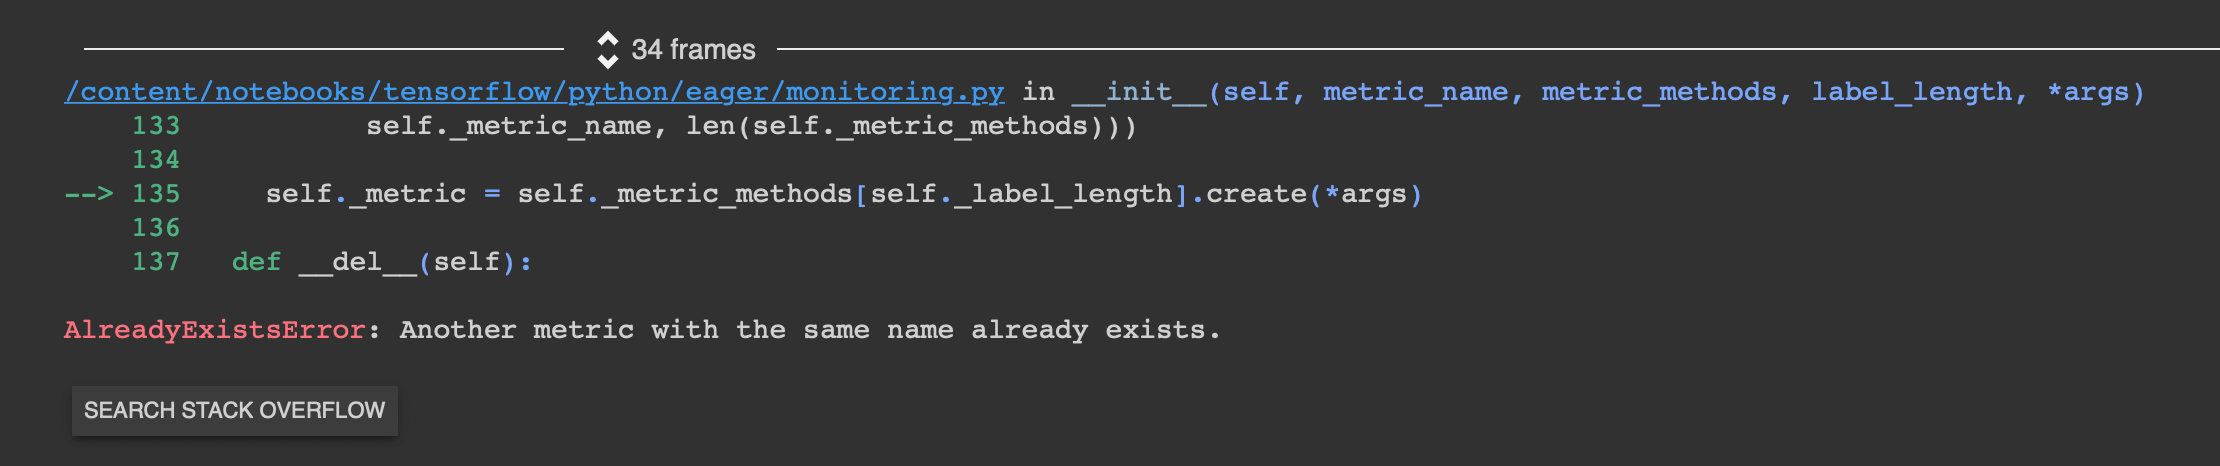

+ 새롭게 배운 것은, 파일을 다운로드 받아서 연결하는게 아니라 Github repo에서 다이렉트로 받아온 뒤 저장까지 코드로 진행하는 방법이다. 외부에 유용한 자료가 많아서 시간절약에 도움이 되었다.

+ 모델링과 훈련 과정을 설계하는 것이 조금 더 편해졌다. 어떻게 배치하는 것이 더 효율적이고 모델 성능을 높일 수 있는가?를 더 공부하면 금방 모델 성능이 좋아질거라 기대한다. Google Colab Pro는 T4와 P100 GPU를 랜덤 배치하는데 성능 차이가 느껴질 정도다. GPU를 확인하는 코드는 꼭 자주 사용해야겠다.

+ 한국어 전처리는 역시 쉽지 않다. 게다가 Going Deeper 첫 과제부터 Accuracy 목표치를 달성하지 못한점도 한편으론 아쉽다. 하이퍼파라미터 수정은 수십번을 했기 때문에, 근본 원인을 되짚어보면 코드에 문제가 좀 있었던 것 같다. 
  - 특히 17번 진행내용에서, corpus_final과 label 그룹이 클렌징된 ‘naver_movie_review_cleaned[‘document’], [‘label’]’로 지정됐어야 했는데 ‘naver_movie_review_df[‘document’],[‘label’]’로 지정하지 않으면 에러가 해결되지 않았다. 그래서 Accuracy에 방해가 되지 않았을까? 생각이 든다. 생각보다 많은 고민을 했던 영역인데 동기분들이 해결한 과정을 들여다보면 금방 해결할 수 있지 않을까 하는 기대감이 든다.

+ Going Deeper에 접어들면서, Deep ML과 심화학습 이론 내용을 이해해서 코드에 적용하는 체감을 느끼면서 기분이 남다르다. 이런 기분좋은 마음을 가지고 수료까지 매일 성장하는 모습을 이끌어가고 싶다.